# Advanced Structural Analysis and Dynamics 5 – ENG5274

## Course Work 1 - Euler–Bernoulli Beam Theory

February 2023
Mihail Todorov 2401456t


---



In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import math

# Overview
In this report, you will develop and validate a finite element code written in Python for solving Euler–Bernoulli beam theory. 
The code will extend the one you developed for a linear elastic bar in 1D. 

The report is to be uploaded to Moodle by 8 March 2022 (by 15:00).

# Submission requirements
## Report 
The main report document should clearly and logically address all the tasks. Marks will be deducted for poor presentation. The report is to be submitted on-line via Moodle - hard-copies will not be marked.

You are to write the report in the Jupyter Notebook format (IPython) using Markdown for the written report. 
You can use Google Colab, Jupyter Notebook or your favourite IPython file editor. 

For more information on Markdown see <https://guides.github.com/pdfs/markdown-cheatsheet-online.pdf>. 
You need to submit:
* the *.ipynb* containing the write up and code.
No other documents will be accepted.

## Code

* Your code needs to be commented and documented.
* You must include the validation examples in your submission.

# Primary functions
Primary functions to compute the element stiffness matrix $\mathbf{K}^e$, the element force vector due to distributed loading $\mathbf{f}_\Omega^e$ and the local to global degree of freedom map.

In [3]:
# the first function get_Ke takes two arguments - le (lenght of the element) as well as the material properties of the element EIe and returns a numpy array (matrix) of the stiffness matrix
# associated with a single element using Euler Bernoulli beam theory

def get_Ke(le, EIe):
    '''Return element stiffness matrix
    Parameters
    ----------
    le : double
      Length of element
    EIe : double
      Product of Young's modulus and moment of inertia
  '''
    
    return (EIe / (le*le*le)) * np.array([[12, 6*le, -12, 6*le], 
                                     [6*le, 4*le*le, -6*le, 2*le*le], 
                                     [-12, -6*le, 12, -6*le], 
                                     [6*le, 2*le*le, -6*le, 4*le*le]])
  

# the second function get_fe_omega takes two argumens - le (length of the element) and fe the uniformly distributed load on the particular element
# for the case of point loads we are going to separately attach those to the force matrix that is acting on the entire structure, attaching them individually to the correct nodes

def get_fe_omega(le, fe):
  '''Return force vector due to distributed loading
    Parameters
    ----------
    le : double
      Length of element
    fe : double
      Average distributed load on element
  '''
  return (fe * le / 2) * np.array([[1], [le/6], [1], [-le/6]])


# the third function get_dof_index takes one argument - e, which is the number of the particular element and returns all degrees of freedom associated with this element - naturally since an element
# has 2 nodes associated with it and each of those can both deflect and rotate ther would be a total of 4 degrees of freedom associated with an individual element and those will be as follows:

def get_dof_index(e):
  '''Return the global dof associated with an element
    Parameters
    ----------
    e : int
      Element ID
  '''
  return [e*2, e*2 + 1, e*2+2, e*2 + 3]

In [4]:
# a quick test to see if the functions previously created work properly and output correctly

print(get_dof_index(0))
print(get_Ke(1e4, 12))

[0, 1, 2, 3]
[[ 1.44e-10  7.20e-07 -1.44e-10  7.20e-07]
 [ 7.20e-07  4.80e-03 -7.20e-07  2.40e-03]
 [-1.44e-10 -7.20e-07  1.44e-10 -7.20e-07]
 [ 7.20e-07  2.40e-03 -7.20e-07  4.80e-03]]


# Validation problems
Consider a 12 m beam with $EI = 1e4$ Nm. Ensure that your code is indeed producing the correct results by comparing the computed  deflection and possibly rotation with the analytical solution for the following loading conditions:
1. An end-loaded cantilever beam with point load of $P = -10$ N acting at $x = 12$ m. The beam is fully fixed at $x=0$. Compare the computed tip deflection and rotation with the analytical solution.
2. A cantilever beam with a distributed load of $f = -1$ N/m acting over the length of the beam. The beam is fully fixed at $x=0$. Compare the computed tip deflection and rotation with the analytical solution.
3. An off-center-loaded simple beam with a point load of $P = -10$ N acting at $x = 3$ m. Deflections are 0 at $x=0$ and $x=L$. Ensure that the load acts at a node. You only need to compare your solution to the analytical solution for the position of, and deflection at, the point of maximum displacement. 
4. A uniformly-loaded simple beam with a distributed load of $f = -1$ N/m acting over the length of the beam. Deflections are 0 at $x=0$ and $x=L$. You only need to compare the deflection along the length of the beam to the analytical solution.

Where possible, you should test your code for one element and for multiple elements. 

Consult <https://en.wikipedia.org/wiki/Deflection_(engineering)> for analytical solutions and descriptions of the loading. 


## Validation - Cantilever with point load

Validation: cantilever with tip load
------------------------------------
Reaction force:  [10.] 	 Reaction moment:  [120.]
Computed tip deflection:  [-0.576] 	 Analytical tip deflection:  -0.576
Computed tip rotation:  [-0.072] 	 Analytical tip rotation:  -0.072


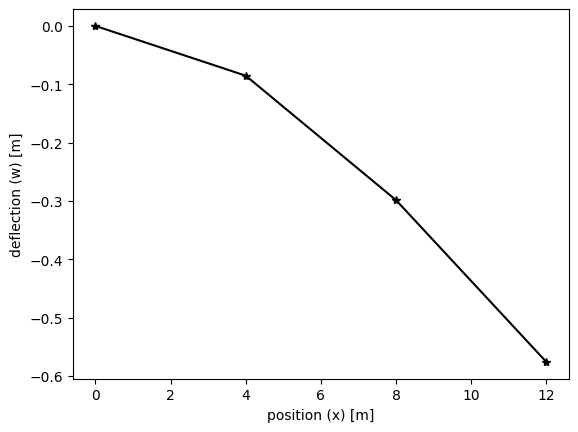

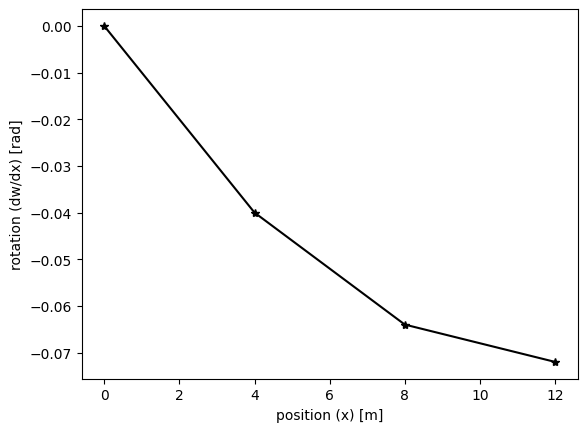

In [5]:
# properties of EB theory
dof_per_node = 2

# domain data
L = 12.

# material and load data
P = -10. # the point load magnitude with negative sign to indicate the direction of the force
P_x = L # locationg of the point load at x = l
f_e = 0. # distributed force introduced into the system
EI = 1e4

# mesh data
n_el = 3 # number of finite elements implemented in the solution
n_np = n_el + 1 # number of nodes conprising the finite element mesh
n_dof = n_np * dof_per_node #the degrees of freedom of the entire global system
x = np.linspace(0, L, n_np) # linspace returns the equally spaced numbers in a particular range 
#     from 0 to the length of the beam spaced evenly by n_np amount
le = L / n_el # the lenght of the individual element, in this case the elements are of the same size

K = np.zeros((n_dof, n_dof)) # the initial version of the stiffness matrix, initially filled with zeroes
f = np.zeros((n_dof, 1)) # the initial version of the force matrix, initially filled with zeroes

# print(x)

for ee in range(n_el): # loop over each finite element to complete the global 
#     stiffness matrix from each element
    dof_index = get_dof_index(ee) # the degrees of freedom associated with each index 
#     from the for loop (connected to each finite element)
    K[np.ix_(dof_index, dof_index)] +=  get_Ke(le, EI) # insert each of the elements local 
#     stiffness matrix into the global one
    f[np.ix_(dof_index)] += get_fe_omega(le, f_e) # same thing with the global force matrix,
#     in this case the fe_omega will be a zero matrix, coming from the fact that f_e is zero

node_P = np.where(x == P_x)[0][0]
f[2*node_P] += P

free_dof = np.arange(2, n_dof)

K_free = K[np.ix_(free_dof, free_dof)]
f_free = f[np.ix_(free_dof)]

# print(node_P)
# print(free_dof)
# solve the linear system
# print(K_free)
# print(f_free)
w_free = np.linalg.solve(K_free, f_free)
w = np.zeros((n_dof, 1))
w[2:] = w_free

# reaction force
rw = K[0,:].dot(w) - f[0]
rtheta = K[1,:].dot(w) - f[1]

# analytical solution
w_analytical = (P * L**3) / (3*EI)
theta_analytical = (P * L**2) / (2*EI)

print('Validation: cantilever with tip load')
print('------------------------------------')
print('Reaction force: ', rw, '\t Reaction moment: ', rtheta)
print('Computed tip deflection: ', w[-2], '\t Analytical tip deflection: ', w_analytical)
print('Computed tip rotation: ', w[-1], '\t Analytical tip rotation: ', theta_analytical)

plt.plot(x,w[0::2],'k-*')
plt.xlabel('position (x) [m]')
plt.ylabel('deflection (w) [m]')
plt.show()

plt.plot(x,w[1::2],'k-*')
plt.xlabel('position (x) [m]')
plt.ylabel('rotation (dw/dx) [rad]')
plt.show()

## Validation - Cantilever with distributed load

Validation: cantilever with uniformly distributed load
------------------------------------------------------
Reaction force:  [12.] 	 Reaction moment:  [72.]
Computed tip deflection:  [-0.2592] 	 Analytical tip deflection:  -0.2592
Computed tip rotation:  [-0.0288] 	 Analytical tip rotation:  -0.0288


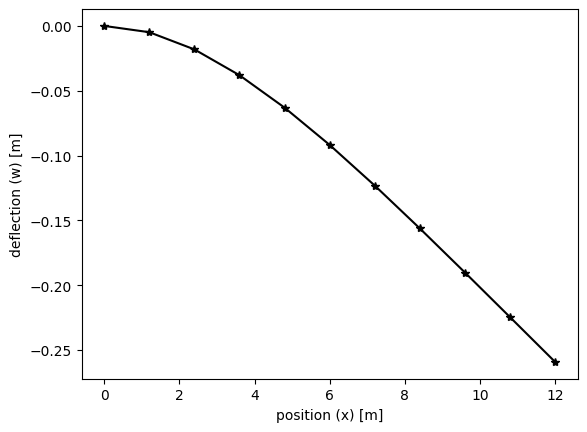

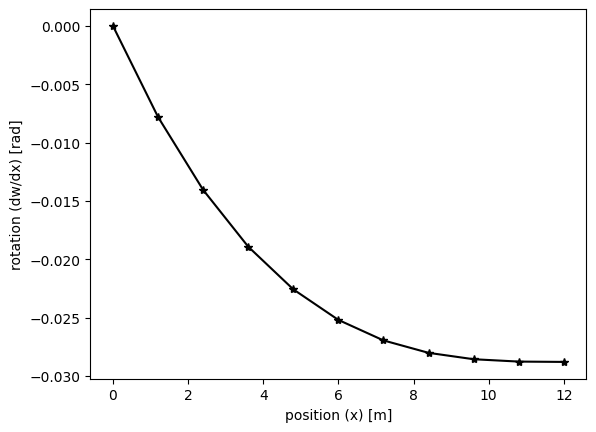

In [6]:
# material and load data
P = 0. # in this case the point load is zero, but we need it so it can be initialized
f_e = -1. # the distributed load is negative acting in the negative y direction with a magnitude of 1

# mesh data
n_el = 10
n_np = n_el + 1
n_dof = n_np * dof_per_node
x = np.linspace(0, L, n_np)
le = L / n_el 

K = np.zeros((n_dof, n_dof)) # arrange a Global stiffness matrix with size the degrees of 
# freedom filled with zeroes
f = np.zeros((n_dof, 1))

for ee in range(n_el): # loop over each finite element to arrange the global stiffness and force matrices
    dof_index = get_dof_index(ee)
    K[np.ix_(dof_index, dof_index)] +=  get_Ke(le, EI)
    f[np.ix_(dof_index)] += get_fe_omega(le, f_e)
    
    
free_dof = np.arange(2, n_dof)
K_free = K[np.ix_(free_dof, free_dof)]
f_free = f[np.ix_(free_dof)]

# solve the linear system
w_free = np.linalg.solve(K_free,f_free)
w = np.zeros((n_dof, 1))
w[2:] = w_free

# reaction force
rw = K[0,:].dot(w) - f[0]
rtheta = K[1,:].dot(w) - f[1]

# analytical solution
w_analytical = (f_e * L**4) / (8*EI)
theta_analytical = (f_e * L**3) / (6*EI)

print('Validation: cantilever with uniformly distributed load')
print('------------------------------------------------------')
print('Reaction force: ', rw, '\t Reaction moment: ', rtheta)
print('Computed tip deflection: ', w[-2], '\t Analytical tip deflection: ', w_analytical)
print('Computed tip rotation: ', w[-1], '\t Analytical tip rotation: ', theta_analytical)

plt.plot(x,w[0::2],'k-*')
plt.xlabel('position (x) [m]')
plt.ylabel('deflection (w) [m]')
plt.show()

plt.plot(x,w[1::2],'k-*')
plt.xlabel('position (x) [m]')
plt.ylabel('rotation (dw/dx) [rad]')
plt.show()


## Validation - Off-center-loaded simple beam


Validation: cantilever with tip load
------------------------------------
Reaction force at first support:  [7.5] 	 Reaction force at second support:  [2.5]
Computed highest deflection:  -0.025083333333336996 	 Analytical highest deflection:  -0.025155764746872634
Computed highest rotation:  -0.007750000000000966 	 Analytical highest rotation:  -0.0072


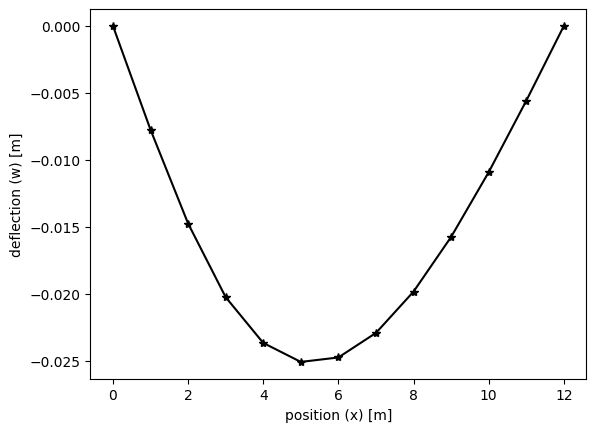

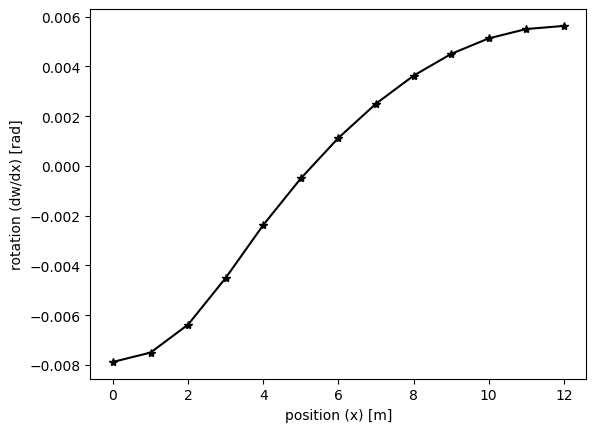

In [7]:
# properties of EB theory
dof_per_node = 2

# domain properties
L = 12.

# material and load data
P = -10. 
P_x = 3 # locationg of the point load
f_e = 0. # distributed force introduced into the system
EI = 1e4

# mesh data
n_el = 12 # number of finite elements implemented in the solution
n_np = n_el + 1 # number of nodes conprising the finite element mesh
n_dof = n_np * dof_per_node # the degrees of freedom of the entire global system
x = np.linspace(0, L, n_np) # linspace returns the equally spaced numbers in a particular range from 0 to the length of the beam
le = L / n_el # the lenght of the individual element, in this case the elements are of the same size

K = np.zeros((n_dof, n_dof)) # the initial version of the stiffness matrix, initially filled with zeroes
f = np.zeros((n_dof, 1)) # the initial version of the force matrix, initially filled with zeroes


for ee in range(n_el): # loop over each finite element to complete the global stiffness matrix from
#     each element
    dof_index = get_dof_index(ee) # the degrees of freedom associated with each index from the for 
#     loop (connected to each finite element)
    K[np.ix_(dof_index, dof_index)] +=  get_Ke(le, EI) # insert each of the elements local stiffness 
#     matrix into the global one
    f[np.ix_(dof_index)] += get_fe_omega(le, f_e) # same thing with the global force matrix, in this 
#     case the fe_omega will be a zero matrix, coming from the fact that f_e is zero

# find where the point load is acting and then add the point load to the force vector at the correct place
node_P = np.where(x == P_x)[0][0]
f[2*node_P] += P
# print(node_P)

free_dof = np.arange(1, n_dof - 2)
free_dof = np.append(free_dof, n_dof - 1)
# print(free_dof)

K_free = K[np.ix_(free_dof, free_dof)]
f_free = f[np.ix_(free_dof)]
# print(f)

# solve the linear system
w_free = np.linalg.solve(K_free,f_free)
w = np.zeros(n_dof)
w[free_dof] = w_free.T

# reaction force
r1 = K[0,:].dot(w) - f[0]
r2 = K[-2,:].dot(w) - f[-2]

# analytical solution
w_analytical = (P * P_x) * ((L ** 2 - P_x ** 2) ** (3/2))/ (9*math.sqrt(3)*L*EI)
theta_analytical = (P * L**2) / (2*EI * 10)


node_highest_deflection = np.where(x == 5)[0][0]
print('Validation: cantilever with tip load')
print('------------------------------------')
print('Reaction force at first support: ', r1, '\t Reaction force at second support: ', r2)
print('Computed highest deflection: ', w[2 * node_highest_deflection], '\t Analytical highest deflection: ', w_analytical)
print('Computed highest rotation: ', w[2], '\t Analytical highest rotation: ', theta_analytical)

plt.plot(x,w[0::2],'k-*')
plt.xlabel('position (x) [m]')
plt.ylabel('deflection (w) [m]')
plt.show()

plt.plot(x,w[1::2],'k-*')
plt.xlabel('position (x) [m]')
plt.ylabel('rotation (dw/dx) [rad]')
plt.show()



## Validation -  Simple beam with distributed loading

Validation: cantilever with uniformly distributed load
------------------------------------------------------
Reaction force:  [12.] 	 Reaction moment:  [72.]
Computed highest deflection:  -0.026999999999985324 	 Analytical highest deflection:  -0.027
Computed highest rotation:  0.007199999999996144 	 Analytical highest rotation:  -0.00576


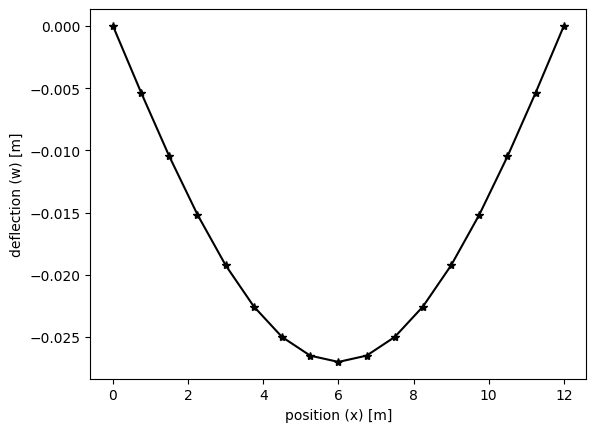

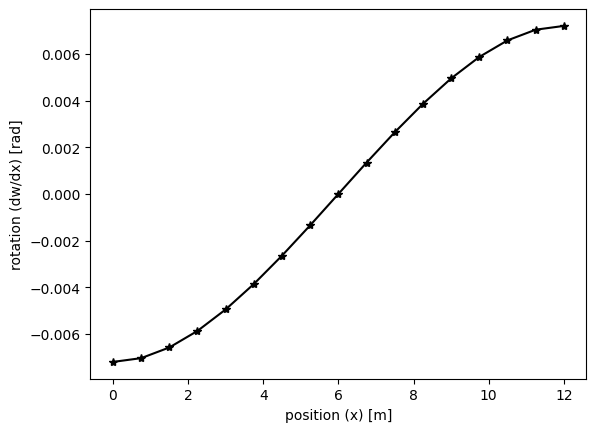

In [8]:
# material and load data
P_x = 3. # the location of point load is at the same spot as the previous example, but its magnitude is zero
f_e = -1. # the distributed load is acting downwards
EI = 1e4
P = 0. # the point load magnitude is equal to zero

# the point load will not be added into the force vector at all - meaning both its position and zero
# assigned magnitude will not contribute at all to the overall solution of the finite element
# problem

# mesh data
n_el = 16 # number of finite elements implemented in the solution
n_np = n_el + 1 # number of nodes conprising the finite element mesh
n_dof = n_np * dof_per_node # the degrees of freedom of the entire global system
x = np.linspace(0, L, n_np) # linspace returns the equally spaced numbers in a particular range from 0 to the length of the beam
le = L / n_el # the lenght of the individual element, in this case the elements are of the same size

K = np.zeros((n_dof, n_dof)) # the initial version of the stiffness matrix, initially filled with zeroes
f = np.zeros((n_dof, 1)) # the initial version of the force matrix, initially filled with zeroes


for ee in range(n_el): # loop over each finite element to complete the global stiffness matrix from
#     each element
    dof_index = get_dof_index(ee) # the degrees of freedom associated with each index from the for 
#     loop (connected to each finite element)
    K[np.ix_(dof_index, dof_index)] +=  get_Ke(le, EI) # insert each of the elements local stiffness 
#     matrix into the global one
    f[np.ix_(dof_index)] += get_fe_omega(le, f_e) # same thing with the global force matrix, in this 
#     case the fe_omega will be a zero matrix, coming from the fact that f_e is zero

# we need to make the deflection zero at the first node and at the last one
free_dof = np.arange(1, n_dof - 2)
free_dof = np.append(free_dof, n_dof - 1)
# print(free_dof)

K_free = K[np.ix_(free_dof, free_dof)]
f_free = f[np.ix_(free_dof)]

# solve the linear system
w_free = np.linalg.solve(K_free, f_free)
w = np.zeros(n_dof)
w[free_dof] = w_free.T

# reaction force
r1 = K[0,:].dot(w) - f[0]
r2 = K[-2,:].dot(w) - f[-2]

# analytical solution
w_analytical = (5 * f_e * L**4) / (384*EI)
theta_analytical = (f_e * L**3) / (6 * EI * 5)


node_highest_deflection = np.where(x == 6)[0][0]

print('Validation: cantilever with uniformly distributed load')
print('------------------------------------------------------')
print('Reaction force: ', rw, '\t Reaction moment: ', rtheta)
print('Computed highest deflection: ', w[2 * node_highest_deflection], '\t Analytical highest deflection: ', w_analytical)
print('Computed highest rotation: ', w[-1], '\t Analytical highest rotation: ', theta_analytical)

plt.plot(x,w[0::2],'k-*')
plt.xlabel('position (x) [m]')
plt.ylabel('deflection (w) [m]')
plt.show()

plt.plot(x,w[1::2],'k-*')
plt.xlabel('position (x) [m]')
plt.ylabel('rotation (dw/dx) [rad]')
plt.show()





# Problem A: Beam structure with linear loading

Now consider the $L = 12$ m beam shown below. The beam is fully fixed at point A $(x = 0)$. A distributed load of $f(x) = -1$ N/m acts between points A and B. Point loads $P_1 = -10$ N and $P_2 = 5$ N act at $x = 4$ m and $x = 8$ m, respectively. Natural boundary conditions are comprised of a traction $\overline{Q} = -20$ N and a moment $\overline{M} = 20$ Nm both acting at point C $(x = L)$. The product $EI = 1e4$ Nm${}^2$.

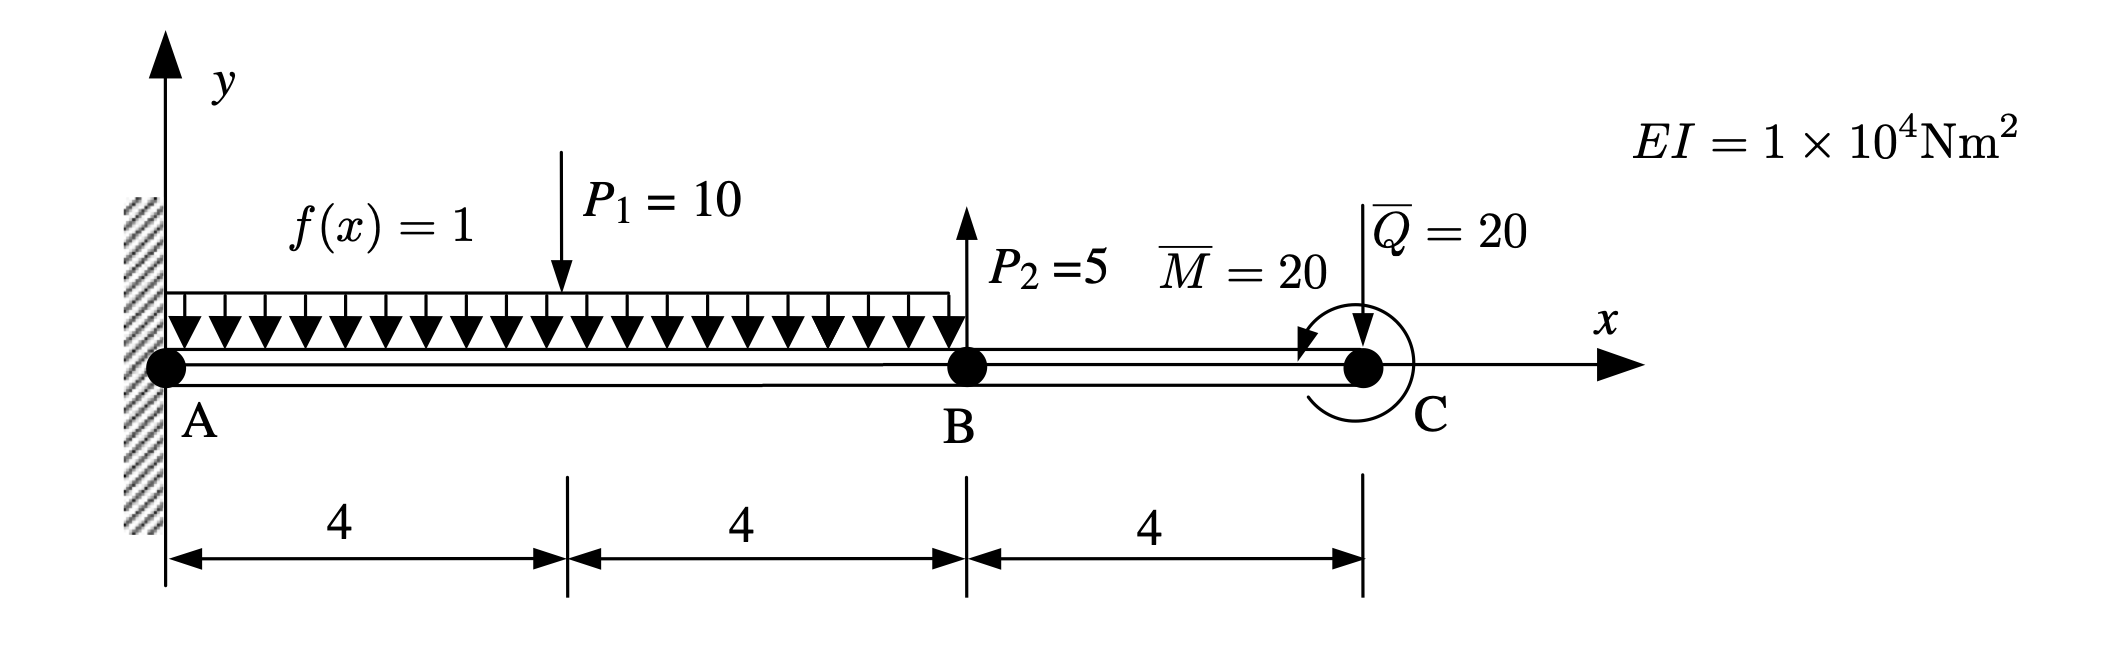

### Assumptions
The code you develop for this problem should assume that the number of elements is a multiple of 3. This will ensure that the point loads are applied directly at a node (why is this important?).

### Outputs
Use your validated code to:
- Determine the reaction force and moment at point A (for 12 elements). Use these to confirm that your output is correct.
- Plot the deflection $w$ over the length of the beam (for 12 elements).
- Plot the rotation $\mathsf{d} w / \mathsf{d} x$ over the length of the beam (for 12 elements).
- Plot the bending moment $M$ over the length of the beam (for 12 elements).


Bending Moment Considerations
<br></br>
The solution for the bending moment M at each node will be based on two separate solutions in order for us to establish a clearer picture of how the moment will behave when computed by the FEM solution. The first approach will take a look at the standard FEA approach for solving this problem - calculating the second derivative of the shape function Be which is related to the Moment M at each node. The second solution will take a slightly different approach - it will attempt to bypass the usage of the shape functions and their derivatives. Since we know that in EB theory the Moment is equal to EIX, The material properties - E (Young's Modulus) and I (The Moment of Inertia), and X - the second derivative of the deflection, or the first derivative of the rotation, we will try to use those, which we already calculated to get the Moment M.
<br></br>

In [9]:
# The first solution and the functions it requires are presented here
# To get Be (the second derivative of the shape function Ne) we need the following function

def get_Be(le, x):
    return (1. / le) * np.array([[6 * x / le], [3 * x - 1], [- 6 * x / le], [3 * x + 1]])

# for ee in range(n_el): # loop over each finite element to complete Be the second derivative of the 
# # shape function
#     dof_index = get_dof_index(ee) # the degrees of freedom associated with each index from the for 
# #     loop (connected to each finite element)
#     K[np.ix_(dof_index, dof_index)] +=  get_Ke(le, EI) # insert each of the elements local stiffness 
# #     matrix into the global one
#     f[np.ix_(dof_index)] += get_fe_omega(le, f_e) # same thing with the global force matrix, in this 
# #     case the fe_omega will be a zero matrix, coming from the fact that f_e is zero



Validation: cantilever with uniformly distributed load
------------------------------------------------------
Reaction force:  [33.] 	 Reaction moment:  [252.]
Computed tip deflection:  [-1.02933333] 	 Analytical tip deflection:  No analytical calculation exists
Computed tip rotation:  [-0.12053333] 	 Analytical tip rotation:  No analytical calculation exists


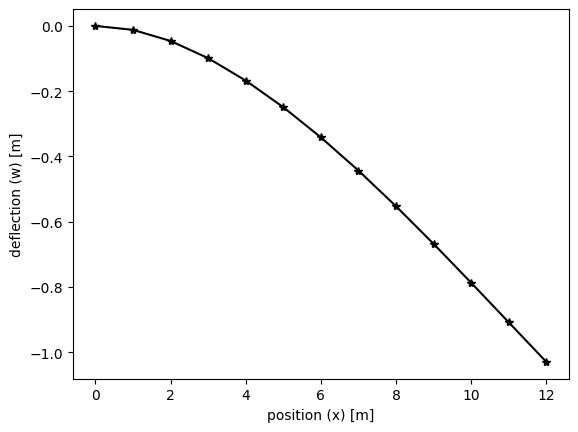

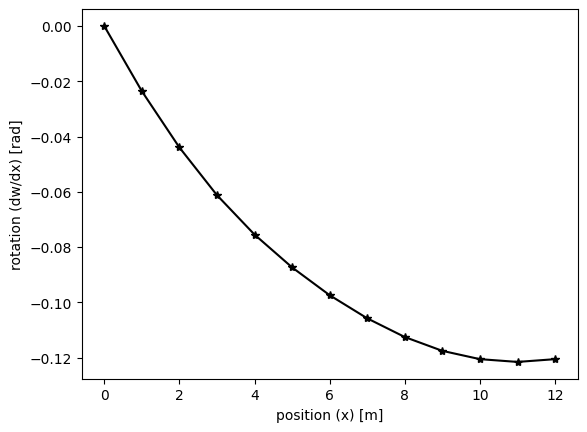

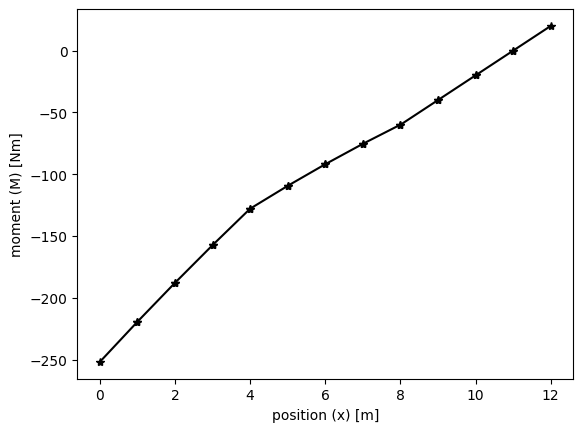

In [14]:
# material and load data
P1 = -10
P1_x = 4
P2 = 5
P2_x = 8
f_e = -1.
EI = 1e4

# mesh data
n = 4
n_el = 3 * n #the number of finite elements that are used should be a multiple of 3, in order to preserve the continuity of the solutiion, since all of the point loads are acting on the thirds of the lenght of the beam
n_np = n_el + 1
n_dof = n_np * dof_per_node
x = np.linspace(0, L, n_np)
#print(x)
le = L / n_el 

K = np.zeros((n_dof, n_dof))
f = np.zeros((n_dof, 1))

# print(f)

for ee in range(n_el): # loop over each finite element to complete the global stiffness matrix from
#     each element
    dof_index = get_dof_index(ee) # the degrees of freedom associated with each index from the for 
#     loop (connected to each finite element)
    K[np.ix_(dof_index, dof_index)] +=  get_Ke(le, EI) # insert each of the elements local stiffness 
#     matrix into the global one

# here the distributed load is acting only on the section of the first 2/3 of the length of the
# beam so it should be added only there and not included in the elements after the first 2/3 of the lenght

    if (ee/n_el) < (2/3):
        f[np.ix_(dof_index)] += get_fe_omega(le, f_e) # same thing with the global force matrix, in this 
#     case the fe_omega will be a zero matrix, coming from the fact that f_e is zero
    else:
        pass
    

# print(K)
# print(f)

node_P1 = np.where(x == P1_x)[0][0]
f[2*node_P1] += P1

node_P2 = np.where(x == P2_x)[0][0]
f[2*node_P2] += P2

free_dof = np.arange(2, n_dof)

# we need to make the deflection zero at the first node and at the last one
K_free = K[np.ix_(free_dof, free_dof)]
f_free = f[np.ix_(free_dof)]
f_free[-1] += 20
f_free[-2] += -20

# print(K_free)
# print(f_free)
# solve the linear system
w_free = np.linalg.solve(K_free,f_free)
w = np.zeros((n_dof, 1))
w[2:] = w_free

# reaction force
rw = K[0,:].dot(w) - f[0]
rtheta = K[1,:].dot(w) - f[1]

# we now need to compose the Moment at each node - and this can be achieved by following the following formula:
# M = EIX, X - kai which is the second derivative of w (the deflection with respect to time)
# we can calculate X (kai) at each element based on the difference in rotation between each node and
# divide it by the length of the finite element - a process which should be relatively trivial for computation

Moment = np.zeros(n_el * 2)

# loop over all elements of the system and get the degrees of freedom associated with the current element ee, then extract the associated values of w - the deflection and rotation vector,
# transpose them so we can calculate the dot product. Following that we need to get Be - the second derivative of the shape function Ne, we have a formula for that and we extract it for 
# nodes associated with the element - node 1 of the element epsilon = -1, and node 2 of the element epsilon = 1, following that add the local moment to the global Moment Vector [Moment].

for ee in range(n_el):
    dof_index = get_dof_index(ee)
    d_ee = w[dof_index].T
    B_e_1 = get_Be(le, -1.)
    B_e_2 = get_Be(le, 1.)
    M_e_1 = EI * d_ee.dot(B_e_1)
    M_e_2 = EI * d_ee.dot(B_e_2)
    Moment[ee * 2] = M_e_1
    Moment[ee * 2 + 1] = M_e_2
    
x_position = np.zeros(2 * n_el)
x_position[0::2] = x[0: -1]
x_position[1::2] = x[1:]

print('Validation: cantilever with uniformly distributed load')
print('------------------------------------------------------')
print('Reaction force: ', rw, '\t Reaction moment: ', rtheta)
print('Computed tip deflection: ', w[-2], '\t Analytical tip deflection: ', "No analytical calculation exists")
print('Computed tip rotation: ', w[-1], '\t Analytical tip rotation: ', "No analytical calculation exists")

plt.plot(x,w[0::2],'k-*')
plt.xlabel('position (x) [m]')
plt.ylabel('deflection (w) [m]')
plt.show()

plt.plot(x,w[1::2],'k-*')
plt.xlabel('position (x) [m]')
plt.ylabel('rotation (dw/dx) [rad]')
plt.show()

plt.plot(x_position,Moment,'k-*')
plt.xlabel('position (x) [m]')
plt.ylabel('moment (M) [Nm]')
plt.show()

<br></br>
The second derivation of the bending Moment - expected to produce if not the same, then very similar results.
<br></br>

Validation: cantilever with uniformly distributed load
------------------------------------------------------
Reaction force:  [33.] 	 Reaction moment:  [252.]
Computed tip deflection:  [-1.02933333] 	 Analytical tip deflection:  No analytical calculation exists
Computed tip rotation:  [-0.12053333] 	 Analytical tip rotation:  No analytical calculation exists


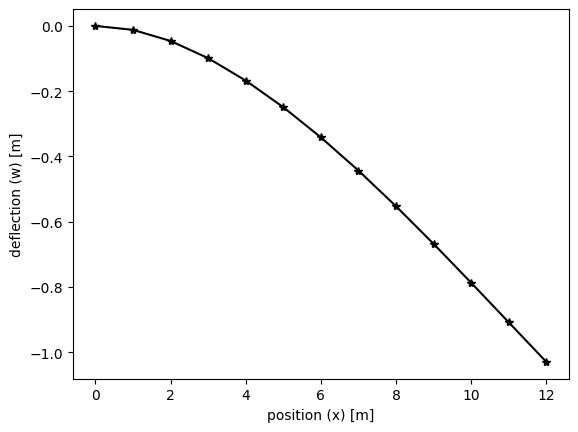

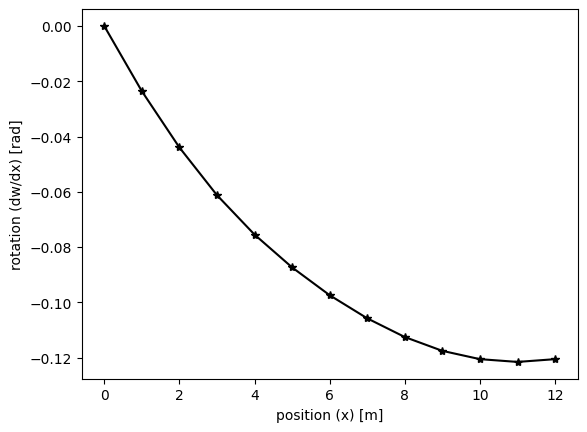

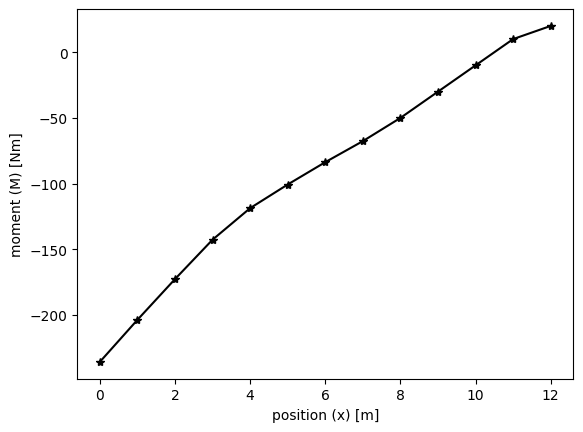

In [15]:
# material and load data
P1 = -10
P1_x = 4
P2 = 5
P2_x = 8
f_e = -1.
EI = 1e4

# mesh data
n = 4
n_el = 3 * n #the number of finite elements that are used should be a multiple of 3, in order to preserve the continuity of the solutiion, since all of the point loads are acting on the thirds of the lenght of the beam
n_np = n_el + 1
n_dof = n_np * dof_per_node
x = np.linspace(0, L, n_np)
#print(x)
le = L / n_el 

K = np.zeros((n_dof, n_dof))
f = np.zeros((n_dof, 1))

# print(f)

for ee in range(n_el): # loop over each finite element to complete the global stiffness matrix from
#     each element
    dof_index = get_dof_index(ee) # the degrees of freedom associated with each index from the for 
#     loop (connected to each finite element)
    K[np.ix_(dof_index, dof_index)] +=  get_Ke(le, EI) # insert each of the elements local stiffness 
#     matrix into the global one

# here the distributed load is acting only on the section of the first 2/3 of the length of the
# beam so it should be added only there and not included in the elements after the first 2/3 of the lenght

    if (ee/n_el) < (2/3):
        f[np.ix_(dof_index)] += get_fe_omega(le, f_e) # same thing with the global force matrix, in this 
#     case the fe_omega will be a zero matrix, coming from the fact that f_e is zero
    else:
        pass
    

# print(K)
# print(f)

node_P1 = np.where(x == P1_x)[0][0]
f[2*node_P1] += P1

node_P2 = np.where(x == P2_x)[0][0]
f[2*node_P2] += P2

free_dof = np.arange(2, n_dof)

# we need to make the deflection zero at the first node and at the last one
K_free = K[np.ix_(free_dof, free_dof)]
f_free = f[np.ix_(free_dof)]
f_free[-1] += 20
f_free[-2] += -20

# print(K_free)
# print(f_free)
# solve the linear system
w_free = np.linalg.solve(K_free,f_free)
w = np.zeros((n_dof, 1))
w[2:] = w_free


# reaction force
rw = K[0,:].dot(w) - f[0]
rtheta = K[1,:].dot(w) - f[1]

# we now need to compose the Moment at each node - and this can be achieved by following the following formula:
# M = EIX, X - kai which is the second derivative of w (the deflection with respect to time)
# we can calculate X (kai) at each element based on the difference in rotation between each node and
# divide it by the length of the finite element - a process which should be relatively trivial for computation

rotations = w[1::2]
#print(rotations)
Moment = np.zeros(((n_np), 1))
#print(Moment)

length = n_np

for i in range(length - 1):
    Moment[i] = EI * (rotations[i + 1] - rotations[i]) / (x[i + 1] - x[i])

Moment[-1] = 20

print('Validation: cantilever with uniformly distributed load')
print('------------------------------------------------------')
print('Reaction force: ', rw, '\t Reaction moment: ', rtheta)
print('Computed tip deflection: ', w[-2], '\t Analytical tip deflection: ', "No analytical calculation exists")
print('Computed tip rotation: ', w[-1], '\t Analytical tip rotation: ', "No analytical calculation exists")

plt.plot(x,w[0::2],'k-*')
plt.xlabel('position (x) [m]')
plt.ylabel('deflection (w) [m]')
plt.show()

plt.plot(x,w[1::2],'k-*')
plt.xlabel('position (x) [m]')
plt.ylabel('rotation (dw/dx) [rad]')
plt.show()

plt.plot(x,Moment,'k-*')
plt.xlabel('position (x) [m]')
plt.ylabel('moment (M) [Nm]')
plt.show()

<br></br>
From the two implemented methods calculating the bending moment of the beam plotted against the position we can clearly see that both results show very similar structural behavior. This fact is reassuring regarding the correctness of the methodology used. The few minor differences (and in particular the fact that the second to last node of the beam in the second method has positive bending moment) can be attributed to the different calculation procedure. Both solutions will asymptotically go to the same values in the limit, where delta le goes to zero. So these observations naturally raise the question - Which model approach is more correct, closer to the truth? The answer depends on a few things, but the second solution will be more correct when the finite elements increase (the mesh size reduces), while the first will be universally more applicable to a broader range of structural situations.
In conclusion this proves that many different approaches might exist for the derivation of a particular solution as well as the algorithms that make it work and some of those can be simultaneously correct, taking a different path to reach the same values.
<br></br>

# Problem B: Beam structure with nonlinear loading

Problem B is identical to that considered in Problem A but the distributed load is given by
\begin{align*}
f(x) = -\sin (\pi x / 8) && \text{for} && 0 \leq x \leq 8 \, .
\end{align*}
Furthermore, the material properties are no longer constant and
\begin{align*}
EI = 1e4 (13 - x)\, \text{ Nm}^2 \, .
\end{align*}

For meshes of $3,3^2,3^3,3^4$ elements, generate plots of
- deflection (at $x=4$ m) versus the number of degrees of freedom.
- $ \sqrt{\int_0^\ell w^2(x) \, \mathsf{d} x}$ versus the number of degrees of freedom.

Explain the method you have used to perform the numerical integration - provide a validation example that shows your method works.

Comment on the convergence of the solution. 


In [12]:
# Since we have both applied force and Material properties that are varying with position we create two
# additional functions to help calculate f and EI in each discrete node
# Both of those functions are of course functions of x, the position (or the coordinate of the node) 
# under investigation

# Since the force is again only acting on the portion of the beam from x = 0 to x = 8 m we create and 
# additional if statement to return the proper value computed as a function of the postion x in the 
# [0, 8] range and return 0 for the rest of the beam
# It is important to note that since we have a similar if statement in the main body of the composition
# of the force matrix this step is only optional, but is established for clarity and readibility

def get_f_e_non_uniform(x):
    if x < 0 or x > 8:
        return 0
    else:
        return - math.sin(math.pi * x / 8) # for x in the [0, 8] domain
    

def get_EI_non_uniform(x):
    return 1e4 * (13 - x)
    

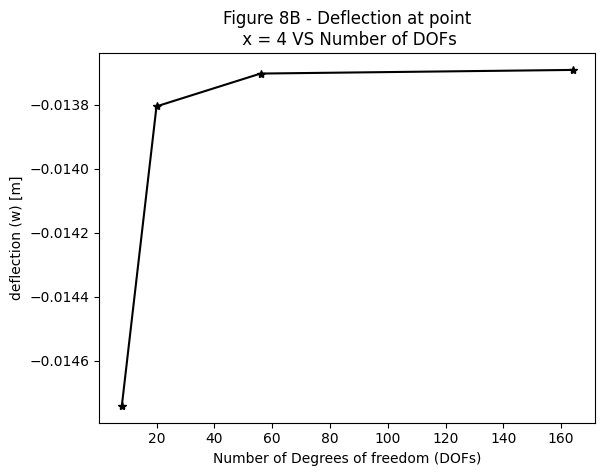

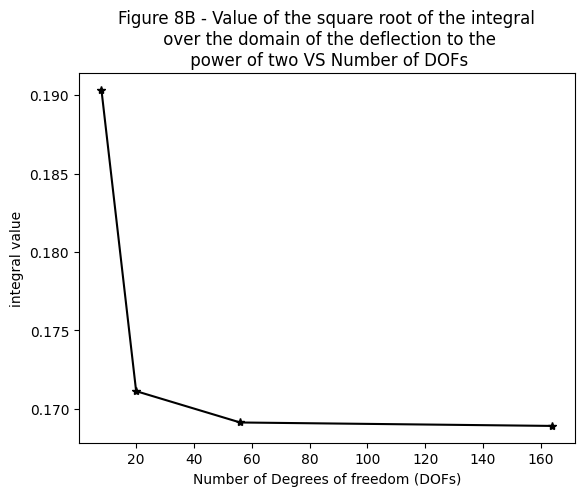

In [13]:
# material and load data
P1 = -10
P1_x = 4
P2 = 5
P2_x = 8
f_e = -1.

# mesh data
mesh_size = [1, 3, 9, 27]
# a list to safe all of the values that we are going to plot
deflection_at_point_x_4 = []
# similarly a list to safe all of the values we are going to plot 
integral_values = []

# we need to loop over the entire solution FEA algorithm for EB theory to calculate the deflection and the
# integral value so we can plot it agains the number of the degrees of freedom

# for n in mesh_size - we loop over all different mesh sizings to composed the desired graph and find if the solution will asymptotically go to the TRUE value.
for n in mesh_size:
    
    # n  = 1 / 3 / 9 / 27
    
    n_el = 3 * n # the number of finite elements that are used should be a multiple of 3, in order to preserve the continuity of the solutiion, since all of the point loads are acting on the 
                 # thirds of the lenght of the beam we input a value from the user and then multiply it by 3 - the user cannot input a value that is not divisible by three.
        
    n_np = n_el + 1
    n_dof = n_np * dof_per_node
    x = np.linspace(0, L, n_np)
    le = L / n_el 

    K = np.zeros((n_dof, n_dof))
    f = np.zeros((n_dof, 1))

    # print(f)

    for ee in range(n_el): # loop over each finite element to complete the global stiffness matrix from
    #     each element
        position_x = (ee + 0.5) * le # 
        dof_index = get_dof_index(ee) # the degrees of freedom associated with each index from the for 
    #     loop (connected to each finite element)
        EI = get_EI_non_uniform(position_x)
        K[np.ix_(dof_index, dof_index)] +=  get_Ke(le, EI) # insert each of the elements local stiffness 
    #     matrix into the global one

    
    # here the distributed load is acting only on the section of the first 2/3 of the length of the
    # beam so it should be added only there and not included in the elements after the first 2/3 of the lenght
        f_e = get_f_e_non_uniform(position_x)

        if (ee/n_el) < (2/3):
            f[np.ix_(dof_index)] += get_fe_omega(le, f_e) # same thing with the global force matrix, in this 
    #     case the fe_omega will be a zero matrix, coming from the fact that f_e is zero
        else:
            pass


    # print(K)
    # print(f)

    node_P1 = np.where(x == P1_x)[0][0]
    f[2*node_P1] += P1

    node_P2 = np.where(x == P2_x)[0][0]
    f[2*node_P2] += P2

    free_dof = np.arange(2, n_dof)

    # we need to make the deflection zero at the first node and at the last one
    K_free = K[np.ix_(free_dof, free_dof)]
    f_free = f[np.ix_(free_dof)]
    f_free[-1] += 20
    f_free[-2] += -20

    # print(K_free)
    # print(f_free)

    # solve the linear system
    w_free = np.linalg.solve(K_free,f_free)
    w = np.zeros((n_dof, 1))
    w[2:] = w_free

    # reaction force
    rw = K[0,:].dot(w) - f[0]
    rtheta = K[1,:].dot(w) - f[1]

    # analytical solution
    w_analytical = (f_e * L**4) / (8*EI)
    theta_analytical = (f_e * L**3) / (6*EI)

    # we need to append the deflection at point x = 4 for each of the mesh sized which should be done here
    # the deflection at point x = 4 can be computed from w, we already have calculated - we need the 
    # element of the vector corresponding to the 
    
    deflection_at_point_x_4.append(w[int(n_el * 2/3)])
    
    # we can calculate the integral required in the brief by calculating the area under the curve of the plotted deflection to the power of two against the positin x
    # the calculation of the integral will take the following approach: to calculate the area under the curve we will optain the area between two nodes by taking the average of w ** 2 between
    # the two points and multiply it by the length of the element, once we have combined all of these element associated areas we will take the square root of the scalar value.
    # once this is done we will plot the result against the mesh size (or the number of degrees of freedom)
    
    # create a new list which takes the deflection associated values from w and sets them to the power of two to get all deflections squared
    deflection_array = [j ** 2 for j in w[0::2]]
    
    length = len(deflection_array)
    
    # set an integral value equal to zero which we will use to sum all areas under the curve
    integral_value = 0
    
    # loop over each of the elements to calculate the integral
    for i in range(length - 1):
        
        # calculate the instanteneous deflection squared for each element by taking the average of the nodal deflections then multiply by the length of the element and add to the integral value
        instanteneous_deflection_w2 = (deflection_array[i] + deflection_array[i + 1]) / 2 
        integral_value += instanteneous_deflection_w2 * le
    
    # get the square root of the integral value as required by the brief
    integral_value = math.sqrt(integral_value)
    # append to the integral values list so we can plot in later stages
    integral_values.append(integral_value)
    
#     print('Validation: cantilever with uniformly distributed load')
#     print('------------------------------------------------------')
#     print('Reaction force: ', rw, '\t Reaction moment: ', rtheta)
#     print('Computed tip deflection: ', w[-2], '\t Analytical tip deflection: ', w_analytical)
#     print('Computed tip rotation: ', w[-1], '\t Analytical tip rotation: ', theta_analytical)

#     plt.plot(x,w[0::2],'k-*')
#     plt.xlabel('position (x) [m]')
#     plt.ylabel('deflection (w) [m]')
#     plt.show()

#     plt.plot(x,w[1::2],'k-*')
#     plt.xlabel('position (x) [m]')
#     plt.ylabel('rotation (dw/dx) [rad]')
#     plt.show()


fig = plt.plot([(m * 3 + 1)*2 for m in mesh_size], deflection_at_point_x_4,'k-*')
plt.title("Figure 8B - Deflection at point\n x = 4 VS Number of DOFs")

plt.xlabel('Number of Degrees of freedom (DOFs)')
plt.ylabel('deflection (w) [m]')
plt.show()


fig = plt.plot([(m * 3 + 1) * 2 for m in mesh_size], integral_values,'k-*')
plt.title("Figure 8B - Value of the square root of the integral\n over the domain of the deflection to the\n power of two VS Number of DOFs")

plt.xlabel('Number of Degrees of freedom (DOFs)')
plt.ylabel('integral value')
plt.show()


Figure 8B - Deflection at point x = 4 VS Number of DOFs.
<br></br>
As expected the deflection at a specific point (x = 4) will change depending on the coarseness of the mesh of choice for the FEM analysis. Usually the finer the mesh (the more elements, or DOFs the system has), the better and more accurate the quality of the result. The graph in Figure 8B - Deflection at point x = 4 VS Number of DOFs clearly shows the result converges towards a specific value - which is the TRUE deflection this specific point will experience in this idealized solution. Since we discretize the problem we introduce error, which is only expected to reduce by increasing the number of elements.
<br></br>

Figure 8B - Value of the square root of the integral over the domain of the deflection to the power of two VS Number of DOFs.
<br></br>
Again as expected the value of the integral will converge to the ,TRUE, solution with increasing number of finite elements, or in other words the finer the mesh the more accurate the solution. 
<br></br>
There is no need for further verification or check example since - both the values and the graph behavior are exactly as expected and the results matches any prediction made previously. Following the basic definition of integration should be a sufficient numerical approach on calculating the particular value. Stronger or more complex algorithms could also be applied such as power series or numerical approximations. Some of those might help with space and time complexity, but according to the nature of the problem provided here - the simplest solution is often the best and since computation time and space are not really a concern on this scale there is no need to further try to optimize a solution that produces correct results in a relatively swift fashion.


<br></br>
Since l am incredibly interested in Mechanics, Structural analysis and coding l would appreciate any feedback about the quality of both my solution and the code implemented to execute it. Readability, clarity and consistency were really important for the solution and were a vital consideration throughout - l would like to know if the solution manages to fulfill those.